https://arxiv.org/pdf/1606.03073.pdf

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform, color
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

use_gpu = torch.cuda.is_available()

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, indices, transform=None):
        self.root_dir = root_dir
        self.indices = indices  # Which image numbers to take
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        try:
            edge_name = os.path.join(self.root_dir, 'edges/', str(index + 1) + '.png')
            icon_name = os.path.join(self.root_dir, 'icons/', str(index + 1) + '.png')
            edge = io.imread(edge_name, as_gray=True)
            edge = edge.reshape((120, 120, 1))
            edge = edge.transpose((2, 0, 1))
            icon = io.imread(icon_name)
            icon = color.rgba2rgb(icon)
            icon = icon.transpose((2, 0, 1))

            return edge, icon
        except ValueError:
            print(index)
            raise ValueError

In [3]:
indices = np.arange(1, 10001)
np.random.shuffle(indices)

train_data = ImageDataset('./data/', indices[:7000])
validation_data = ImageDataset('./data/', indices[7000:8500])
test_data = ImageDataset('./data/', indices[8500:])

In [4]:
class Res(nn.Module):
    def __init__(self):
        super(Res, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
        )
        
    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.conv2(y)
        return y + x

    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=9, padding=4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.residual = nn.Sequential(
            Res(),
            Res(),
            Res(),
            Res(),
            Res(),
        )
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=9, padding=4),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.residual(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.final(x)
        return x

In [5]:
BATCH_SIZE = 4
LR = 0.001
EPOCHS = 25

In [6]:
# Second component of loss is a VGG-16 DNN
vgg = models.vgg16(pretrained=True).cuda()
clipped = list(vgg.children())[0][:9]
clipped_model = torch.nn.Sequential(*clipped).cuda()

In [6]:
# Borrowed from https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
# Credit to user Himanshu Tyagi
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


In [8]:
def validate(model, val_loader):
    model.eval()
    val_loss = 0
    for edges, icons in tqdm(val_loader):
        if use_gpu:
            edges = edges.cuda()
        icons = icons.float()
        res = model(edges.float())
        res = res.detach().cpu().numpy()
        icons = icons.numpy()
        val_loss += psnr(res, icons)      
    print(f"Validation PSNR: {val_loss / len(val_loader)}")

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer):
    for e in range(EPOCHS):
        running_loss = 0
        model.train()
        for edges, icons in tqdm(train_loader):
            if use_gpu:
                edges = edges.cuda()
                icons = icons.cuda()
            
            res = model(edges.float())
#             print(res[0])
#             print(icons[0])
#             print(res.shape)
#             print(icons.shape)
            icons = icons.float()
    
            
            loss = criterion(res, icons)
            with torch.no_grad():
                vgg_clip = clipped_model(icons)
            loss += criterion(clipped_model(res), vgg_clip)
            
#             print(icons[:, :, :, :-1])
#             print(icons[:,:,1:,:].shape)
            var_loss = 0.00001 * (torch.sum(torch.sqrt(
                torch.pow(icons[:, :, :, :-1] - icons[:, :, :, 1:], 2).flatten() + \
                torch.pow(icons[:,:,:-1,:] - icons[:,:,1:,:], 2).flatten()
            )))
            
            loss += var_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print(f"Epoch {e+1}")
            print(f"Training loss: {running_loss / len(train_loader)}")
            validate(model, val_loader)

In [7]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [13]:
net = Net()
if use_gpu:
    net = net.cuda()


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8)

train(net, train_loader, validation_loader, criterion, optimizer)


Epoch 1
Training loss: 1.3758543936184475



Validation PSNR: 10.703395256320755



Epoch 2
Training loss: 0.9612137578896114



Validation PSNR: 11.906334205544896



Epoch 3
Training loss: 0.8833379963806697



Validation PSNR: 10.665639243031832



Epoch 4
Training loss: 0.8372574869053704



Validation PSNR: 12.649184758157896



Epoch 5
Training loss: 0.7907763450145722



Validation PSNR: 13.354692121401357



Epoch 6
Training loss: 0.7579229264089039



Validation PSNR: 13.306074182529832



Epoch 7
Training loss: 0.7251307086263384



Validation PSNR: 13.800969589462007



Epoch 8
Training loss: 0.7016713921342578



Validation PSNR: 13.82539754870898



Epoch 9
Training loss: 0.6782462356431144



Validation PSNR: 13.910496084655563



Epoch 10
Training loss: 0.6511988655669348



Validation PSNR: 14.229609383014415



Epoch 11
Training loss: 0.6339321947608675



Validation PSNR: 14.135191231818554



Epoch 12
Training loss: 0.6176373557703836



Validation PSNR: 14.438512803746503



Epoch 13
Training loss: 0.5958799731050218



Validation PSNR: 14.591794423063831



Epoch 14
Training loss: 0.5790038439546312



Validation PSNR: 14.623762009399373



Epoch 15
Training loss: 0.5666462978294917



Validation PSNR: 14.796149295445018



Epoch 16
Training loss: 0.5538654321432114



Validation PSNR: 14.992192732680513



Epoch 17
Training loss: 0.5389305361935071



Validation PSNR: 15.272812821199546



Epoch 18
Training loss: 0.5268234277623041



Validation PSNR: 15.263700919066878



Epoch 19
Training loss: 0.5144130053435053



Validation PSNR: 15.503434372734208



Epoch 20
Training loss: 0.5023371081096786



Validation PSNR: 15.177398283063228



Epoch 21
Training loss: 0.49330180181775773



Validation PSNR: 15.74837598843546



Epoch 22
Training loss: 0.4889867992571422



Validation PSNR: 15.50764493646962



Epoch 23
Training loss: 0.4732492472870009



Validation PSNR: 15.903432814510873



Epoch 24
Training loss: 0.4707472071307046



Validation PSNR: 15.049976209583306



Epoch 25
Training loss: 0.47028747284412387



Validation PSNR: 16.28601680766952


In [22]:
torch.save(net.state_dict(), 'CSI.pt')

In [8]:
net = Net()
device = torch.device('cuda')
net.load_state_dict(torch.load('CSI.pt'))
net.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (residual): Sequential(
    (0): Res(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Ba

In [9]:
def test(model, test_loader, visualize=False, samples=1):
    model.train()
    test_loss = 0
    for edges, icons in tqdm(test_loader):
        if use_gpu:
            edges = edges.cuda()
        
        res = model(edges.float())
        res = res.detach().cpu().numpy()[0,:,:,:]
        icons = icons.float().numpy()[0, :, :, :]
        test_loss += psnr(res, icons)
        
        if visualize and samples > 0:
            samples -= 1
            res = res.transpose((1, 2, 0))
            res = res.clip(0, 1)
            icons = icons.transpose((1, 2, 0))
            edges = edges.detach().cpu().numpy()[0, 0, :, :]
            plt.imshow(edges, cmap='gray')
            plt.axis('off')
            plt.show()
            plt.imshow(res)
            plt.axis('off')
            plt.show()
            plt.imshow(icons)
            plt.axis('off')
            plt.show()
            
    print(f"Test PSNR is {test_loss / len(test_loader)}")

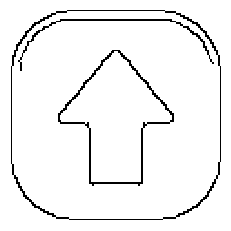

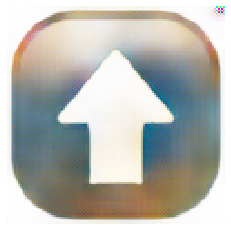

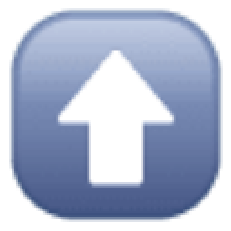


Test PSNR is 14.252988022412756


In [10]:
test(net, test_loader, visualize=True, samples=1)